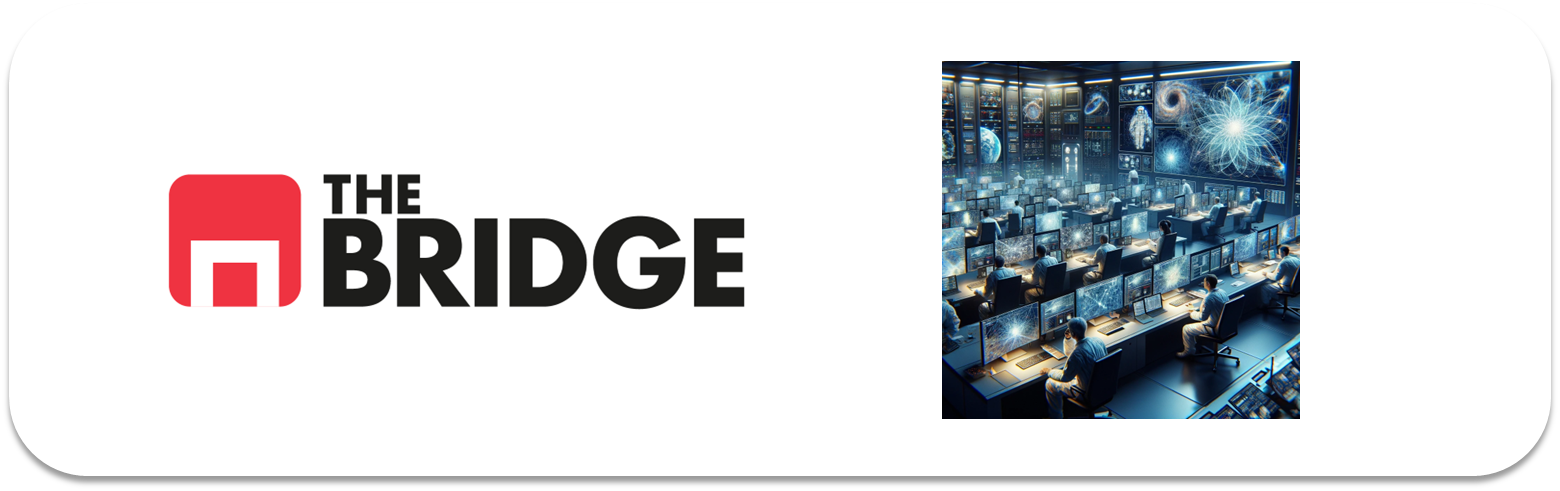

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning con CNN**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.


In [1]:
import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import seaborn as sns

from skimage.io import imread
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

In [2]:
# Hemos probado a descargarlo directamente vía api como novedad.
# Lo dej comentado para que no vuelva a descargarlo si reinicio el código pues son 10min de descarga

#from kaggle.api.kaggle_api_extended import KaggleApi
#
#api = KaggleApi()
#api.authenticate()
#
## Download and unzip the dataset
#api.dataset_download_files('puneet6060/intel-image-classification', path='data', unzip=True)
#
#print("Dataset downloaded to 'data'")

In [3]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

In [4]:
def read_data(directorio, reshape_dim = (32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [5]:
# Transformamos a numpy arrays
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH) # Nota: podríamos dejar la creación de X_test para el final antes de usarlo y así ahorra memoria mientras no tengamos que emplearlo

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [6]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 32, 32, 3)
Y train shape:  (14034,)


In [7]:
print('X train shape: ', X_test.shape)
print('Y train shape: ', y_test.shape)

X train shape:  (3000, 32, 32, 3)
Y train shape:  (3000,)


In [8]:
pd.Series(y_train).value_counts(normalize = True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [9]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

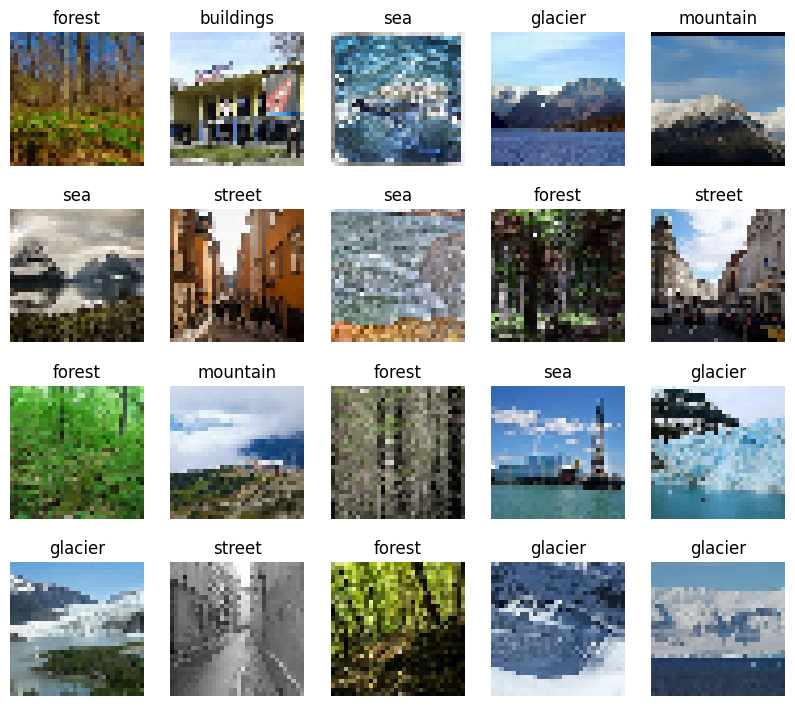

In [10]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [11]:
# Escalamos las imágenes
X_train = X_train / 255
X_test = X_test / 255

In [12]:
# Barajamos los datos, nos interesa hacerlo con train puesto que son a partir de los cuales aprende el modelo
X_train_s, y_train_s = shuffle(X_train, y_train, random_state=42)

In [13]:
# Mapeamos las categorías a números
categorias = np.unique(y_train)
n_categorias = len(categorias)

mapping = {cat: i for i, cat in enumerate(categorias)}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}

In [14]:
# Observamos el mapeo
mapping

{np.str_('buildings'): 0,
 np.str_('forest'): 1,
 np.str_('glacier'): 2,
 np.str_('mountain'): 3,
 np.str_('sea'): 4,
 np.str_('street'): 5}

In [15]:
inverse_mapping

{0: np.str_('buildings'),
 1: np.str_('forest'),
 2: np.str_('glacier'),
 3: np.str_('mountain'),
 4: np.str_('sea'),
 5: np.str_('street')}

In [16]:
# Mapeamos las etiquetas
y_train_num = np.array([mapping[cat] for cat in y_train_s])
y_test_num = np.array([mapping[cat] for cat in y_test])

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

In [17]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import decode_predictions

In [18]:
base_model = keras.applications.VGG19(
    include_top= False, # para poder redimensionar mis imágenes a (32, 32, 3). De otro modo necesita un tamaño mínimo
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="vgg19",
)

In [19]:
base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
tipos = []
def read_random_images_from_subfolders(base_path, num_images=5):
    X = []
    all_image_paths = []
    # Recorremos todas las subcarpetas
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg")):
                all_image_paths.append(os.path.join(root, file))
    # Elegimos aleatoriamente
    selected_files = random.sample(all_image_paths, min(num_images, len(all_image_paths)))
    for file_path in selected_files:
        image = imread(file_path)
        smallimage = cv2.resize(image, (32, 32))
        print("Imagen cargada:", file_path)
        tipos.append(os.path.basename(file_path))
        X.append(smallimage)
    return np.array(X)
# Cargar y procesar 5 imágenes aleatorias desde subcarpetas
x_figs = read_random_images_from_subfolders('./data/seg_train')
x_test = preprocess_input(x_figs)
print("Forma del lote de imágenes procesadas:", x_test.shape)

Imagen cargada: ./data/seg_train\glacier\1320.jpg
Imagen cargada: ./data/seg_train\sea\15009.jpg
Imagen cargada: ./data/seg_train\street\12003.jpg
Imagen cargada: ./data/seg_train\forest\16065.jpg
Imagen cargada: ./data/seg_train\sea\20010.jpg
Forma del lote de imágenes procesadas: (5, 32, 32, 3)


3. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

In [21]:
# Encode labels
categorias = np.unique(y_train)
n_categorias = len(categorias)
mapping = {cat: i for i, cat in enumerate(categorias)}
inverse_mapping = {v: k for k, v in mapping.items()}
y_train_encoded = np.array([mapping[label] for label in y_train])
y_test_encoded = np.array([mapping[label] for label in y_test])

# Convert labels to categorical
y_train_cat = keras.utils.to_categorical(y_train_encoded, num_classes=n_categorias)
y_test_cat = keras.utils.to_categorical(y_test_encoded, num_classes=n_categorias)

In [22]:
# base_model.trainable = False
base_model = VGG19(include_top=False, weights="imagenet", input_shape=(32, 32, 3))

# Añadimos las capas solicitadas
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_categorias, activation='softmax')
])

# Compilamos el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo contra train
history = model.fit(X_train, 
                    y_train_cat, 
                    epochs=10, validation_split=0.2, 
                    batch_size=32,
                    callbacks= [keras.callbacks.EarlyStopping(patience = 3, restore_best_weights= True)]
                    )

# Evaluamos el modelo contra test
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

# Predicciones
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 99s 275ms/step - accuracy: 0.3620 - loss: 1.4254 - val_accuracy: 0.0709 - val_loss: 7.1397
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 288ms/step - accuracy: 0.5873 - loss: 0.9673 - val_accuracy: 0.0000e+00 - val_loss: 8.6079
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 102s 291ms/step - accuracy: 0.6394 - loss: 0.8784 - val_accuracy: 0.0000e+00 - val_loss: 8.1041
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 102s 290ms/step - accuracy: 0.6897 - loss: 0.7918 - val_accuracy: 0.0118 - val_loss: 9.6144
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.6447 - loss: 0.9697
Test Accuracy: 0.4453
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step


In [23]:
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names = categorias, zero_division=0))

Classification Report:
              precision    recall  f1-score   support

   buildings       0.38      0.83      0.52       437
      forest       0.82      0.82      0.82       474
     glacier       0.51      0.08      0.14       553
    mountain       0.38      0.54      0.45       525
         sea       0.35      0.50      0.41       510
      street       0.00      0.00      0.00       501

    accuracy                           0.45      3000
   macro avg       0.41      0.46      0.39      3000
weighted avg       0.40      0.45      0.38      3000



Confusion Matrix:


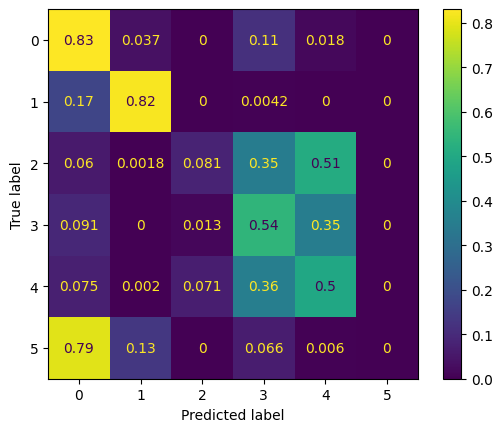

In [24]:
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred, normalize="true")

4. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

In [25]:
# Me vengo arriba y utilizo directamente el codigo de los tutoriales en keras.io
#Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
history_fine = model.fit(X_train, 
                         y_train_cat, 
                         epochs=10, 
                         validation_split=0.2, 
                         batch_size=32, 
                         callbacks= [keras.callbacks.EarlyStopping(patience = 3, restore_best_weights= True)]
                         )

# Evaluamos el modelo contra test
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

# Predicciones
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 100s 278ms/step - accuracy: 0.5271 - loss: 1.1118 - val_accuracy: 0.0000e+00 - val_loss: 9.8857
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 105s 299ms/step - accuracy: 0.6144 - loss: 0.9258 - val_accuracy: 0.0043 - val_loss: 12.1796
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 113s 321ms/step - accuracy: 0.5850 - loss: 1.0144 - val_accuracy: 0.0046 - val_loss: 11.2220
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 114s 324ms/step - accuracy: 0.5938 - loss: 0.9990 - val_accuracy: 0.0000e+00 - val_loss: 14.2125
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.7248 - loss: 0.9576
Test Accuracy: 0.4750
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step


In [31]:
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=categorias, zero_division=0))

Classification Report:
              precision    recall  f1-score   support

   buildings       0.35      0.88      0.50       437
      forest       0.91      0.72      0.81       474
     glacier       0.47      0.72      0.57       553
    mountain       0.45      0.57      0.50       525
         sea       0.00      0.00      0.00       510
      street       0.00      0.00      0.00       501

    accuracy                           0.47      3000
   macro avg       0.36      0.48      0.40      3000
weighted avg       0.36      0.47      0.39      3000



Confusion Matrix:


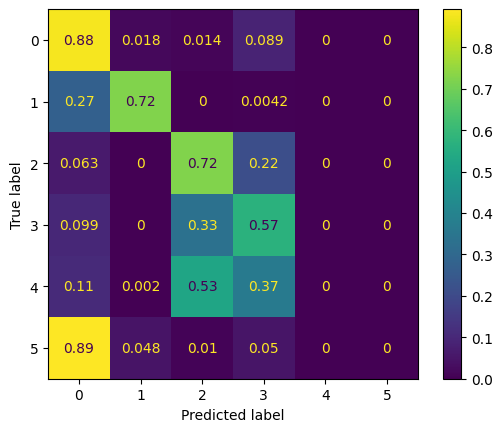

In [30]:
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred, normalize="true")

5. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

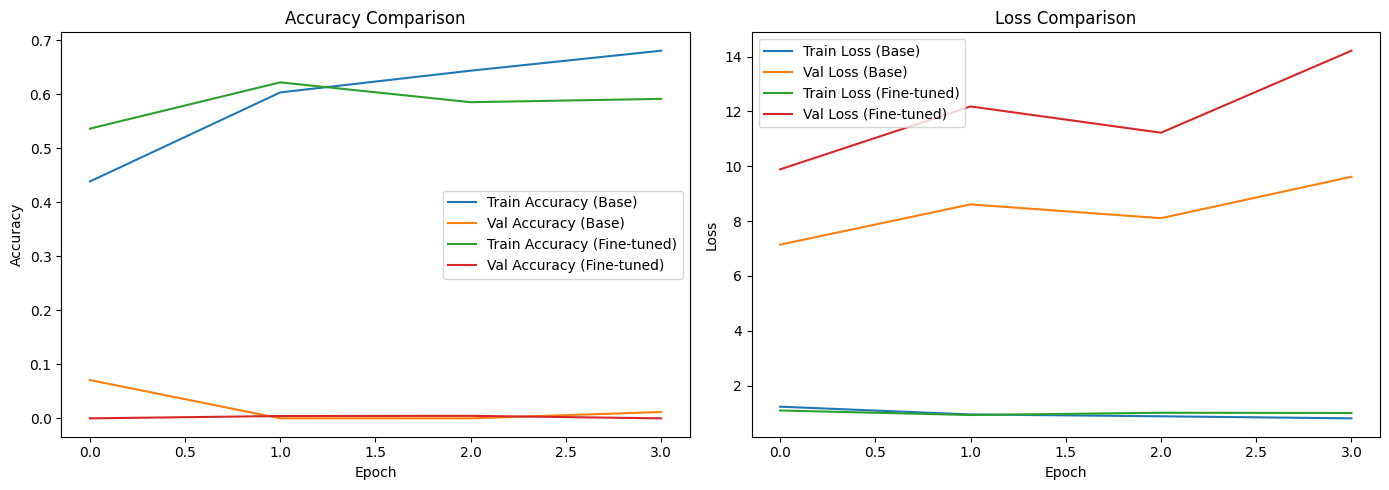

In [32]:
# Comparamos accuracy y loss
def plot_training_history(history, history_fine):
    plt.figure(figsize=(14, 5))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy (Base)')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy (Base)')
    plt.plot(history_fine.history['accuracy'], label='Train Accuracy (Fine-tuned)')
    plt.plot(history_fine.history['val_accuracy'], label='Val Accuracy (Fine-tuned)')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss (Base)')
    plt.plot(history.history['val_loss'], label='Val Loss (Base)')
    plt.plot(history_fine.history['loss'], label='Train Loss (Fine-tuned)')
    plt.plot(history_fine.history['val_loss'], label='Val Loss (Fine-tuned)')
    plt.title('Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history, history_fine)


EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.